In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
%matplotlib inline

### Load Scores and Profile Sizes

In [2]:
def getScores():
    resultDir = "../results/"
    if not os.path.exists(resultDir):
        os.makedirs(resultDir)
    size = loadProfileSizes()

In [3]:
def loadProfileSizes():
    profileSize = dict()
    inFile = open("../data/ProfileSizes.txt")

    for line in inFile:
        entity, size = line.strip().split("\t")
        entity = entity.replace("#profile","")
        entity = entity.replace("http://purl.obolibrary.org/obo/","")
        profileSize[entity] = int(size)

    inFile.close()
    return profileSize

In [4]:
def loadProfiles():
    inFile = open("../data/Scores_Sizes.txt")

    scores = []
    geneProfileSizes = []
    taxonProfileSizes = []

    rawscores = []
    rawGeneProfileSizes = []
    rawTaxonProfileSizes = []

    for line in inFile:
        if "Score" not in line:
            data = line.strip().split("\t")
            score = float(data[6])
            scores.append(score)
            rawGeneProfileSizes.append(int(data[1]))
            rawTaxonProfileSizes.append(int(data[4]))
    inFile.close()
    return scores, rawTaxonProfileSizes, rawGeneProfileSizes

In [5]:
getScores()
scores, rawTaxonProfileSizes, rawGeneProfileSizes = loadProfiles()

### Log Transformation

Create a second scores set with log transformed scores

In [6]:
scoresLog = list(scores)

for x in range(0, len(scoresLog)):
    if scoresLog[x] != 0:
        scoresLog[x] = math.log(scoresLog[x])

# Taxon Profile Sizes

Let's look at taxon profile sizes vs. scores. First, we'll plot all of the data to see what the scatter looks like.

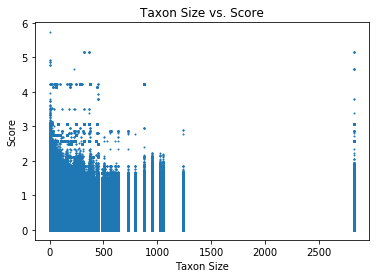

In [7]:
plt.scatter(np.array(rawTaxonProfileSizes), np.array(scores), s=1)
plt.xlabel('Taxon Size')
plt.ylabel('Score')
plt.title('Taxon Size vs. Score')

The range of taxon sizes is pretty high, so it's hard to see enough detail.

Let's load the data into a Pandas DataFrame so we can start to filter the data and create more granular plots.

In [8]:
taxonAndScores = pd.DataFrame(
    {
        'taxonSizes': rawTaxonProfileSizes,
        'scores': scores
    })
taxonAndScores.head()

,scores,taxonSizes
0,0.096137,22
1,0.329889,162
2,0.329889,157
3,0.379192,1029
4,0.065285,34


In [9]:
taxonAndScoresLog = pd.DataFrame(
    {
        'taxonSizes': rawTaxonProfileSizes,
        'scores': scoresLog
    })
taxonAndScoresLog.head()

,scores,taxonSizes
0,-2.341980,22
1,-1.108998,162
2,-1.108998,157
3,-0.969712,1029
4,-2.728988,34


### How should we split the data?

Let's make a histogram to see the distribution of taxon sizes. This will help give a better sense of how to split the data in order to get more detail in our scatter plots.

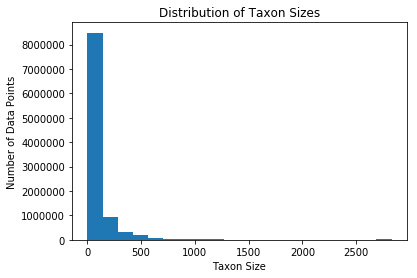

In [10]:
taxonAndScores['taxonSizes'].plot(kind='hist', bins=20, title='Distribution of Taxon Sizes', legend=False)
plt.xlabel('Taxon Size')
plt.ylabel('Number of Data Points')

It looks like the majority of data points are for taxon sizes between 0-250. We can split these points into smaller ranges of taxon sizes and make several scatter plots. This should show more detail in each these graphs.

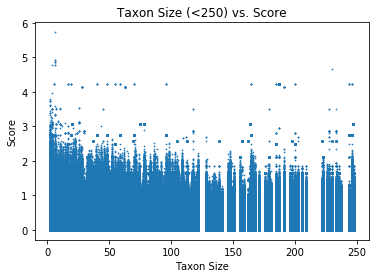

In [11]:
smallTaxa = taxonAndScores[taxonAndScores['taxonSizes'] < 250]
smallTaxa.plot('taxonSizes', 'scores', s=0.5, kind='scatter', title='Taxon Size (<250) vs. Score')
plt.xlabel('Taxon Size')
plt.ylabel('Score')

This is still too messy. Let's split this down even further. Hopefully we'll be able to make out more individual points if we focus on much smaller chunks at a time.

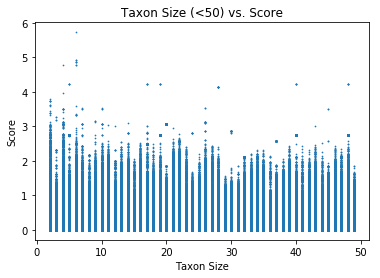

In [12]:
smallTaxa = taxonAndScores[taxonAndScores['taxonSizes'] < 50]
smallTaxa.plot('taxonSizes', 'scores', s=0.5, kind='scatter', title='Taxon Size (<50) vs. Score')
plt.xlabel('Taxon Size')
plt.ylabel('Score')

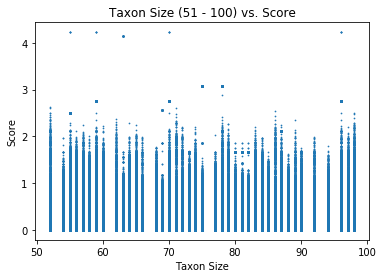

In [13]:
smallTaxa = taxonAndScores[(taxonAndScores['taxonSizes'] > 50) & (taxonAndScores['taxonSizes'] < 100)]
smallTaxa.plot('taxonSizes', 'scores', s=0.5, kind='scatter', title='Taxon Size (51 - 100) vs. Score')
plt.xlabel('Taxon Size')
plt.ylabel('Score')

### Still messy

These are still pretty hard to make out anything useful. It looks like each size has many scores resulting in these vertical bars in the plot.

Let's try taking the average of the scores for each given size and see if that helps.

In [14]:
taxonAndAvgScores = taxonAndScores.groupby('taxonSizes', as_index=False)['scores'].mean()
taxonAndAvgScores.rename(columns={'scores':'avgScores'}, inplace=True)
taxonAndAvgScores.head()

,taxonSizes,avgScores
0,2,0.146084
1,3,0.169026
2,4,0.176314
3,5,0.169552
4,6,0.208292


In [15]:
taxonAndAvgScoresLog = taxonAndScoresLog.groupby('taxonSizes', as_index=False)['scores'].mean()
taxonAndAvgScoresLog.rename(columns={'scores':'avgScores'}, inplace=True)
taxonAndAvgScoresLog.head()

,taxonSizes,avgScores
0,2,-2.206040
1,3,-1.707504
2,4,-1.994858
3,5,-2.011393
4,6,-1.806052


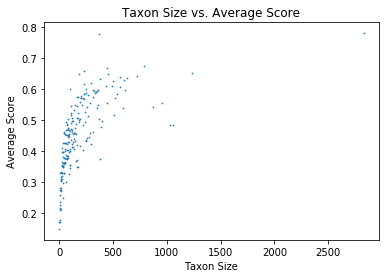

In [16]:
taxonAndAvgScores.plot('taxonSizes', 'avgScores', s=0.5, kind='scatter', title='Taxon Size vs. Average Score')
plt.xlabel('Taxon Size')
plt.ylabel('Average Score')

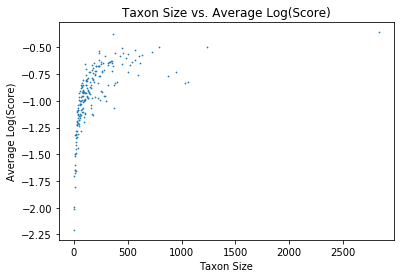

In [17]:
taxonAndAvgScoresLog.plot('taxonSizes', 'avgScores', s=0.5, kind='scatter', title='Taxon Size vs. Average Log(Score)')
plt.xlabel('Taxon Size')
plt.ylabel('Average Log(Score)')

### Much better

It looks like we can start to make out a shape in this plot. Let's split the scatter plot again and see how they look.

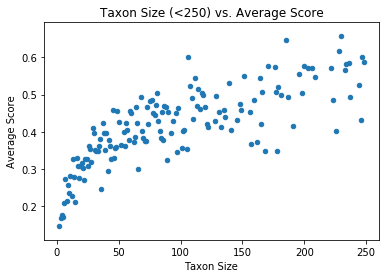

In [18]:
smallTaxa = taxonAndAvgScores[taxonAndAvgScores['taxonSizes'] < 250]
smallTaxa.plot('taxonSizes', 'avgScores', kind='scatter', title='Taxon Size (<250) vs. Average Score')
plt.xlabel('Taxon Size')
plt.ylabel('Average Score')

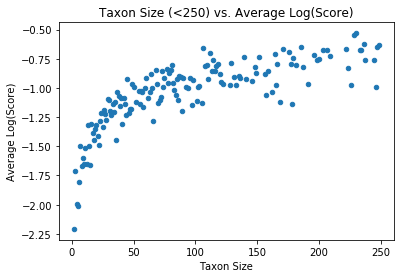

In [19]:
smallTaxaLog = taxonAndAvgScoresLog[taxonAndAvgScoresLog['taxonSizes'] < 250]
smallTaxaLog.plot('taxonSizes', 'avgScores', kind='scatter', title='Taxon Size (<250) vs. Average Log(Score)')
plt.xlabel('Taxon Size')
plt.ylabel('Average Log(Score)')

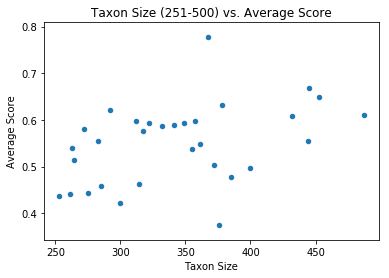

In [20]:
mediumTaxa = taxonAndAvgScores[(taxonAndAvgScores['taxonSizes'] > 250) & (taxonAndAvgScores['taxonSizes'] < 500)]
mediumTaxa.plot('taxonSizes', 'avgScores', kind='scatter', title='Taxon Size (251-500) vs. Average Score')
plt.xlabel('Taxon Size')
plt.ylabel('Average Score')

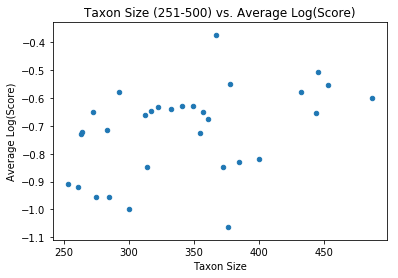

In [21]:
mediumTaxaLog = taxonAndAvgScoresLog[(taxonAndAvgScoresLog['taxonSizes'] > 250) & (taxonAndAvgScoresLog['taxonSizes'] < 500)]
mediumTaxaLog.plot('taxonSizes', 'avgScores', kind='scatter', title='Taxon Size (251-500) vs. Average Log(Score)')
plt.xlabel('Taxon Size')
plt.ylabel('Average Log(Score)')

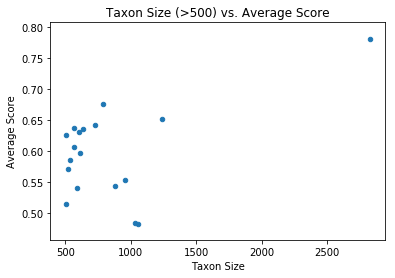

In [22]:
largeTaxa = taxonAndAvgScores[taxonAndAvgScores['taxonSizes'] > 500]
largeTaxa.plot('taxonSizes', 'avgScores', kind='scatter', title='Taxon Size (>500) vs. Average Score')
plt.xlabel('Taxon Size')
plt.ylabel('Average Score')

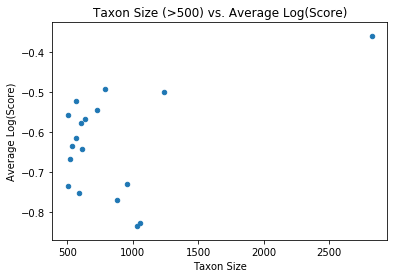

In [23]:
largeTaxaLog = taxonAndAvgScoresLog[taxonAndAvgScoresLog['taxonSizes'] > 500]
largeTaxaLog.plot('taxonSizes', 'avgScores', kind='scatter', title='Taxon Size (>500) vs. Average Log(Score)')
plt.xlabel('Taxon Size')
plt.ylabel('Average Log(Score)')

# Gene Profile Sizes

Now let's look at gene profile sizes vs. scores. Again, we'll first plot all of the data to see what the scatter looks like.

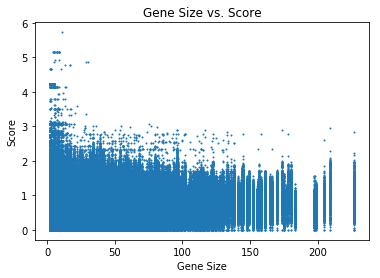

In [24]:
plt.scatter(np.array(rawGeneProfileSizes), np.array(scores), s=1)
plt.xlabel('Gene Size')
plt.ylabel('Score')
plt.title('Gene Size vs. Score')

As expected, this initial scatter is very messy.

We'll follow pretty much the same process as for the taxon sizes, beginning with loading the data into a DataFrame so we can start filtering and making new plots.

In [25]:
geneAndScores = pd.DataFrame(
    {
        'geneSizes': rawGeneProfileSizes,
        'scores': scores
    })
geneAndScores.head()

,geneSizes,scores
0,15,0.096137
1,15,0.329889
2,15,0.329889
3,15,0.379192
4,15,0.065285


In [31]:
geneAndScoresLog = pd.DataFrame(
    {
        'geneSizes': rawGeneProfileSizes,
        'scores': scoresLog
    })
geneAndScoresLog.head()

,geneSizes,scores
0,15,-2.341980
1,15,-1.108998
2,15,-1.108998
3,15,-0.969712
4,15,-2.728988


Let's make another histogram to see the distribution of gene sizes.

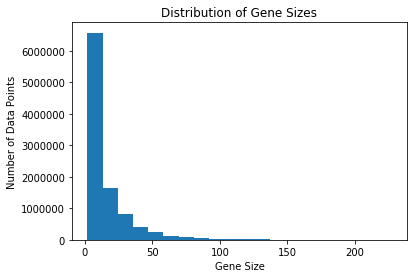

In [27]:
geneAndScores['geneSizes'].plot(kind='hist', bins=20, title='Distribution of Gene Sizes', legend=False)
plt.xlabel('Gene Size')
plt.ylabel('Number of Data Points')

With the gene profile data, it looks like most of our data points fall between 0-20. Let's start splitting this up and looking at smaller plots.

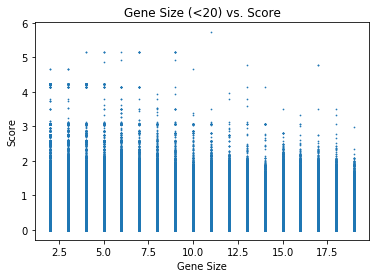

In [28]:
smallGenes = geneAndScores[geneAndScores['geneSizes'] < 20]
smallGenes.plot('geneSizes', 'scores', s=0.5, kind='scatter', title='Gene Size (<20) vs. Score')
plt.xlabel('Gene Size')
plt.ylabel('Score')

### More vertical bars

We're pretty much getting the same results as with the taxa. Each gene size is associated with many scores and that's creating these big vertical bars on the plot.

Let's just go straight to averaging the scores and see how that plot looks.

In [29]:
geneAndAvgScores = geneAndScores.groupby('geneSizes', as_index=False)['scores'].mean()
geneAndAvgScores.rename(columns={'scores':'avgScores'}, inplace=True)
geneAndAvgScores.head()

,geneSizes,avgScores
0,2,0.142727
1,3,0.249560
2,4,0.237031
3,5,0.274980
4,6,0.297623


In [32]:
geneAndAvgScoresLog = geneAndScoresLog.groupby('geneSizes', as_index=False)['scores'].mean()
geneAndAvgScoresLog.rename(columns={'scores':'avgScores'}, inplace=True)
geneAndAvgScoresLog.head()

,geneSizes,avgScores
0,2,-0.823050
1,3,-1.521482
2,4,-1.677779
3,5,-1.660588
4,6,-1.698478


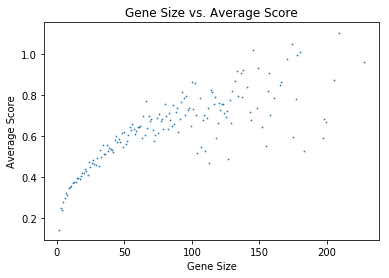

In [33]:
geneAndAvgScores.plot('geneSizes', 'avgScores', s=0.5, kind='scatter', title='Gene Size vs. Average Score')
plt.xlabel('Gene Size')
plt.ylabel('Average Score')

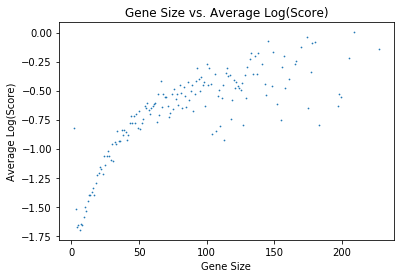

In [34]:
geneAndAvgScoresLog.plot('geneSizes', 'avgScores', s=0.5, kind='scatter', title='Gene Size vs. Average Log(Score)')
plt.xlabel('Gene Size')
plt.ylabel('Average Log(Score)')

### Much better

Let's split this up into smaller plots.

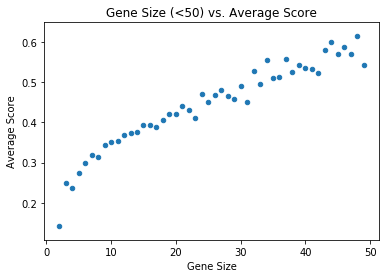

In [35]:
smallGenes = geneAndAvgScores[geneAndAvgScores['geneSizes'] < 50]
smallGenes.plot('geneSizes', 'avgScores', kind='scatter', title='Gene Size (<50) vs. Average Score')
plt.xlabel('Gene Size')
plt.ylabel('Average Score')

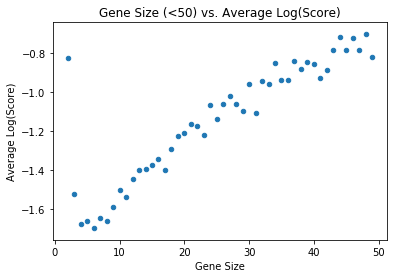

In [36]:
smallGenesLog = geneAndAvgScoresLog[geneAndAvgScoresLog['geneSizes'] < 50]
smallGenesLog.plot('geneSizes', 'avgScores', kind='scatter', title='Gene Size (<50) vs. Average Log(Score)')
plt.xlabel('Gene Size')
plt.ylabel('Average Log(Score)')

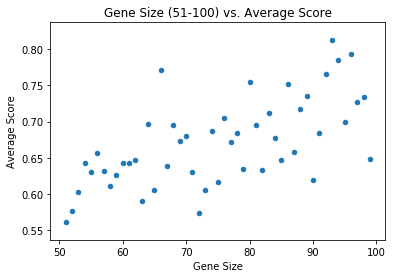

In [37]:
mediumGenes = geneAndAvgScores[(geneAndAvgScores['geneSizes'] > 50) & (geneAndAvgScores['geneSizes'] < 100)]
mediumGenes.plot('geneSizes', 'avgScores', kind='scatter', title='Gene Size (51-100) vs. Average Score')
plt.xlabel('Gene Size')
plt.ylabel('Average Score')

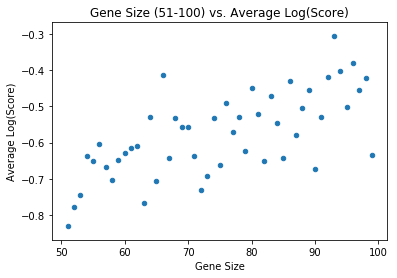

In [38]:
mediumGenesLog = geneAndAvgScoresLog[(geneAndAvgScoresLog['geneSizes'] > 50) & (geneAndAvgScoresLog['geneSizes'] < 100)]
mediumGenesLog.plot('geneSizes', 'avgScores', kind='scatter', title='Gene Size (51-100) vs. Average Log(Score)')
plt.xlabel('Gene Size')
plt.ylabel('Average Log(Score)')

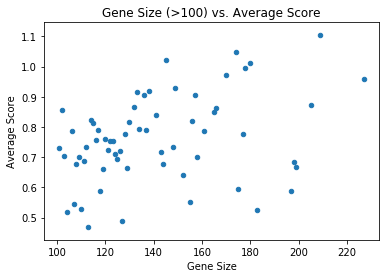

In [39]:
largeGenes = geneAndAvgScores[geneAndAvgScores['geneSizes'] > 100]
largeGenes.plot('geneSizes', 'avgScores', kind='scatter', title='Gene Size (>100) vs. Average Score')
plt.xlabel('Gene Size')
plt.ylabel('Average Score')

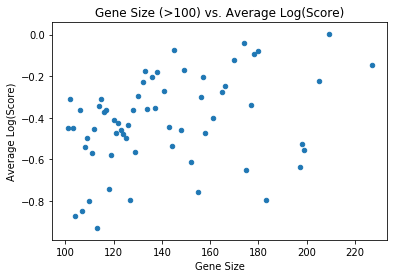

In [40]:
largeGenesLog = geneAndAvgScoresLog[geneAndAvgScoresLog['geneSizes'] > 100]
largeGenesLog.plot('geneSizes', 'avgScores', kind='scatter', title='Gene Size (>100) vs. Average Log(Score)')
plt.xlabel('Gene Size')
plt.ylabel('Average Log(Score)')